Good matches found: 11


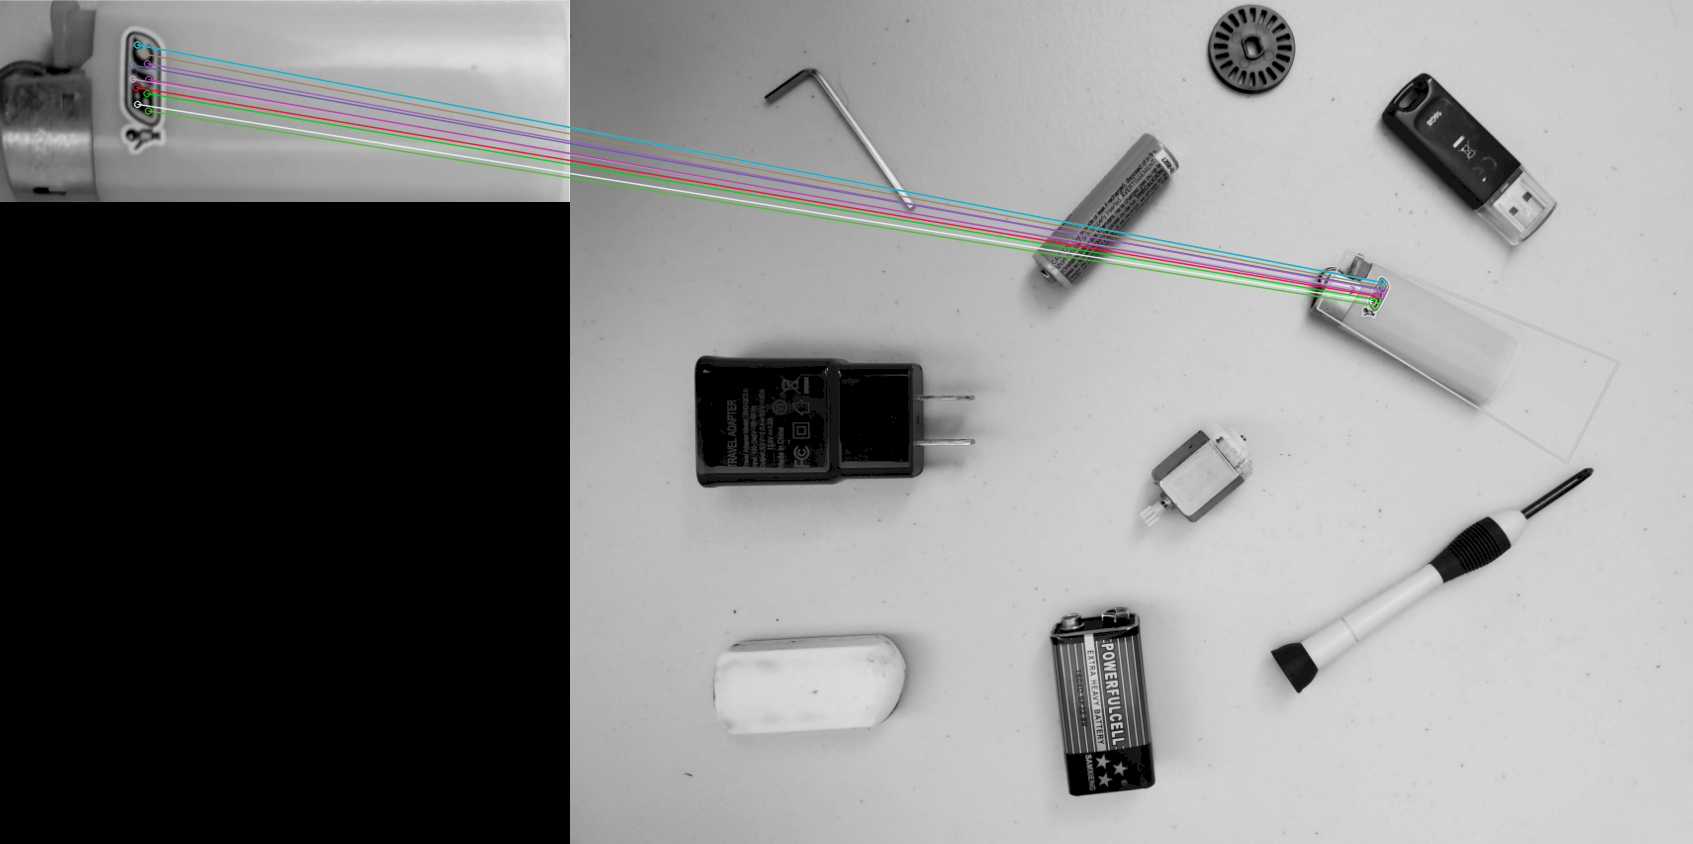

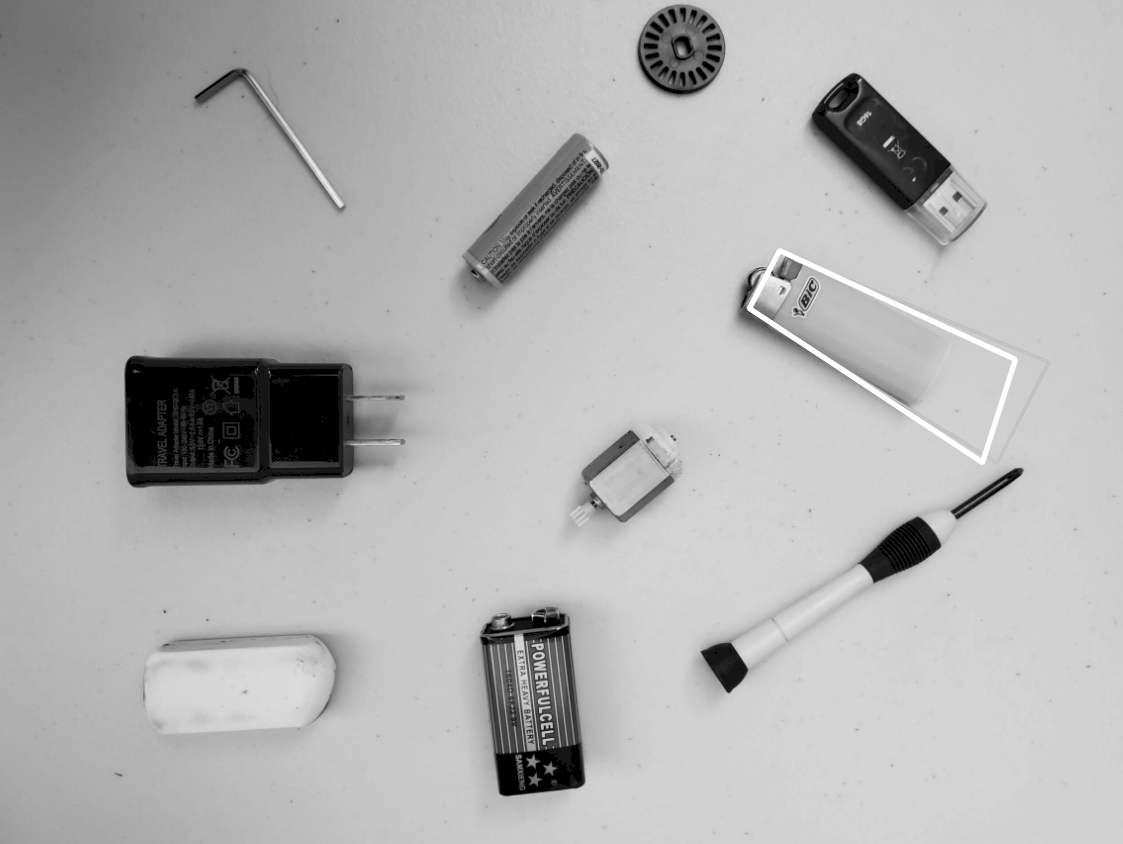

In [20]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def main():
    # Load the full query and target images
    query_image_path = "queryy.jpg"  # <-- Use full object crop here
    target_image_path = "targett.jpg"
    query_img = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)
    target_img = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

    if query_img is None or target_img is None:
        print("Error: One or both images not found.")
        return

    sift = cv2.SIFT_create()
    kp_query, des_query = sift.detectAndCompute(query_img, None)
    kp_target, des_target = sift.detectAndCompute(target_img, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query, des_target, k=2)

    # Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    print(f"Good matches found: {len(good_matches)}")

    if len(good_matches) > 10:
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_target[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if matrix is not None:
            h, w = query_img.shape
            pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, matrix)
            result_img = cv2.polylines(target_img.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

            match_img = cv2.drawMatches(query_img, kp_query, target_img, kp_target, good_matches, None, flags=2)
            cv2_imshow(match_img)
            cv2_imshow(result_img)
        else:
            print("Homography could not be computed.")
    else:
        print("Not enough good matches.")

if __name__ == "__main__":
    main()